<a href="https://colab.research.google.com/github/yokesh412/Time-series-forecast/blob/main/Store_Sales_time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

**Importing the datasets and perform EDA**

Transaction

1.From this data set we will get three major details.

2.transaction gives the total transactions for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

3.store_nbr identifies the store at which the products are sold.

In [ ]:
transac = pd.read_csv('/content/drive/MyDrive/time series forecat project/transactions.csv')
print(transac.head(10))
transac.info()

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922
5  2013-01-02          5          1903
6  2013-01-02          6          2143
7  2013-01-02          7          1874
8  2013-01-02          8          3250
9  2013-01-02          9          2940
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


From above we can see that date column data type is object. Lets make it to datetime format for further analysis.

In [ ]:
transac['date'] = pd.to_datetime(transac['date'])

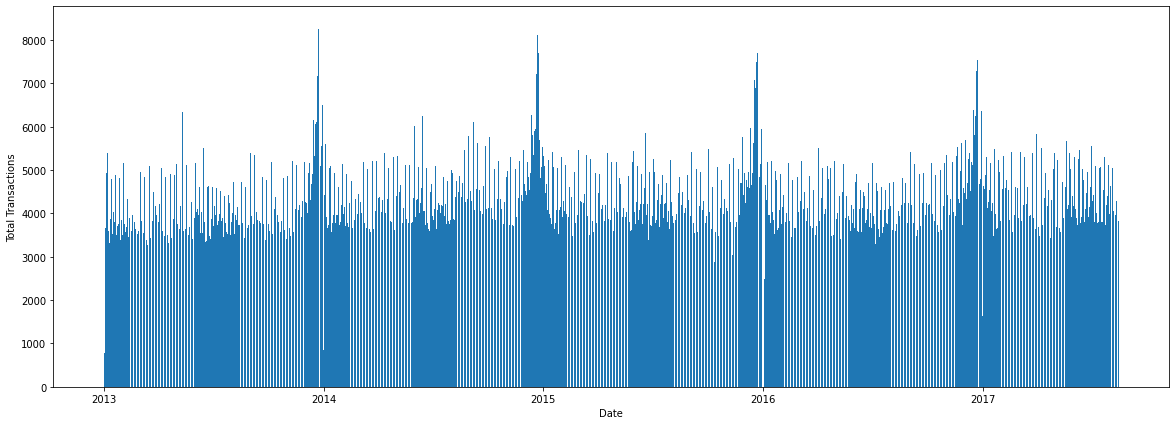

In [ ]:
#Lets analyse the transaction made each day. We can get a clear idea from a graphical view.
fig=plt.figure(figsize=(20,7))
plt.bar(transac['date'],transac['transactions'])
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.show()


From above we can clearly see that the transaction on decmber month of each year is too high. Specially from december 12th. That may be because of holidays and vacation season.
Lets analyse the transaction made on each store. We can get a clear idea from a graphical view.¶

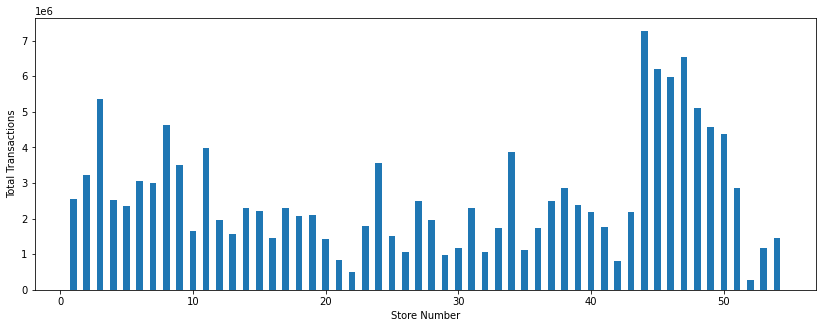

In [ ]:
transac_store = transac[['store_nbr','transactions']].groupby('store_nbr').sum()
transac_store = transac_store.reset_index()
fig = plt.figure(figsize = (14, 5)) 
plt.bar(transac_store['store_nbr'], transac_store['transactions'],width=0.5)
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.show()

From above we can clearly see that store number 3, 8, 11, 44, 45, 46, 47, 48, 49 and 50 have lot of transactions i.e. sales is very good in these regions and we can focus on these.¶

**Stores:-**

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

Import the data set and see a overall details

In [ ]:
stores = pd.read_csv('/content/drive/MyDrive/time series forecat project/stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


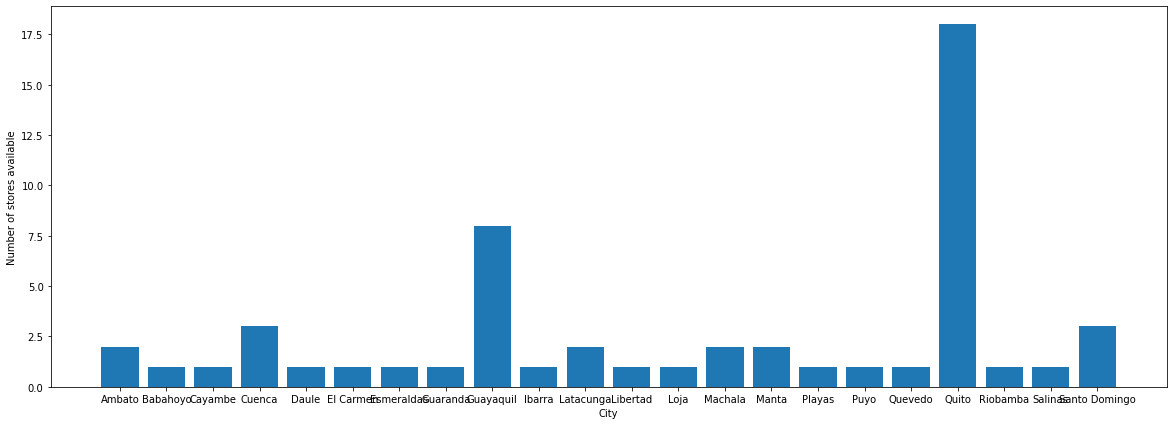

In [ ]:
#Lets see the number of stores available in each city.
stores_city=stores[['city','store_nbr']].groupby('city').count()
stores_city=stores_city.reset_index()
fig=plt.figure(figsize=(20,7))
plt.bar(stores_city['city'],stores_city['store_nbr'])
plt.xlabel('City')
plt.ylabel('Number of stores available')
plt.show()

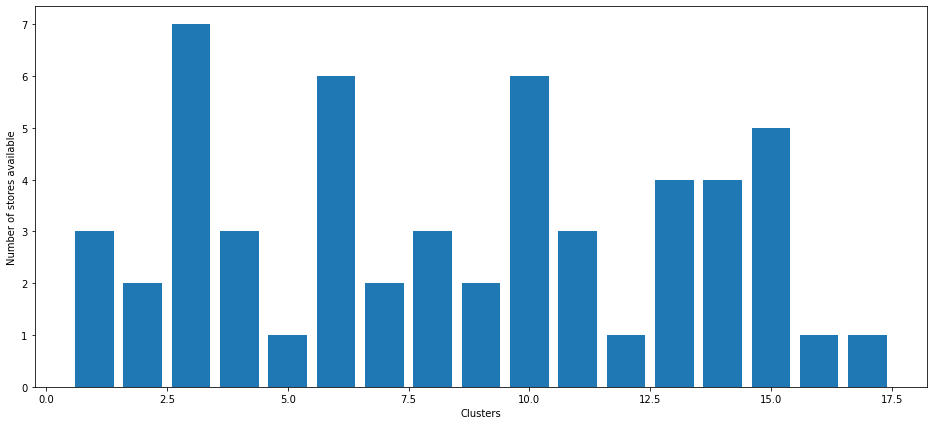

In [ ]:
#Lets see the number of stores available in each clusters.
stores_city=stores[['cluster','store_nbr']].groupby('cluster').count()
stores_city=stores_city.reset_index()
fig=plt.figure(figsize=(16,7))
plt.bar(stores_city['cluster'],stores_city['store_nbr'])
plt.xlabel('Clusters')
plt.ylabel('Number of stores available')
plt.show()

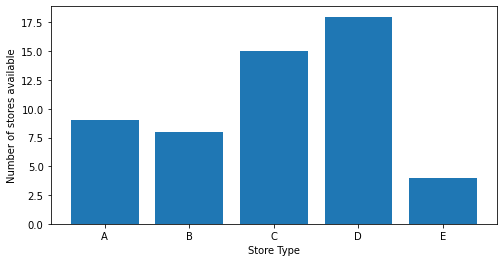

In [ ]:
#Lets see the number of stores available in each type of store.
stores_city=stores[['type','store_nbr']].groupby('type').count()
stores_city=stores_city.reset_index()
fig=plt.figure(figsize=(8,4))
plt.bar(stores_city['type'],stores_city['store_nbr'])
plt.xlabel('Store Type')
plt.ylabel('Number of stores available')
plt.show()

Train Dataset

1.The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

2.store_nbr identifies the store at which the products are sold.

3.family identifies the type of product sold.

4.sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

5.onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [ ]:
#importing the datsets
train=pd.read_csv('/content/drive/MyDrive/time series forecat project/train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


From above we can see that date column data type is object. Lets make it to datetime format for further analysis.

In [ ]:
train['date'] = pd.to_datetime(train['date'])

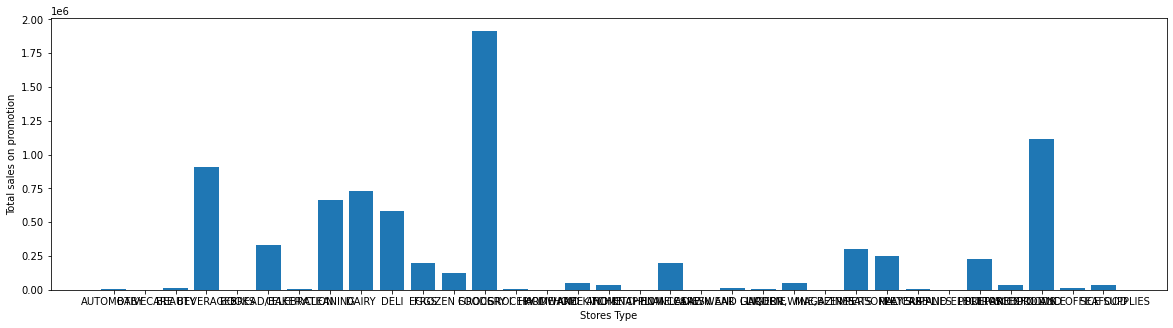

In [ ]:
#Lets analyse the total onpromotion i.e product family that were being promoted at a store
store_family=train[['family','onpromotion']].groupby('family').sum()
store_family=store_family.reset_index()
fig=plt.figure(figsize=(20,5))
plt.bar(store_family['family'],store_family['onpromotion'])
plt.xlabel('Stores Type')
plt.ylabel('Total sales on promotion')
plt.show()

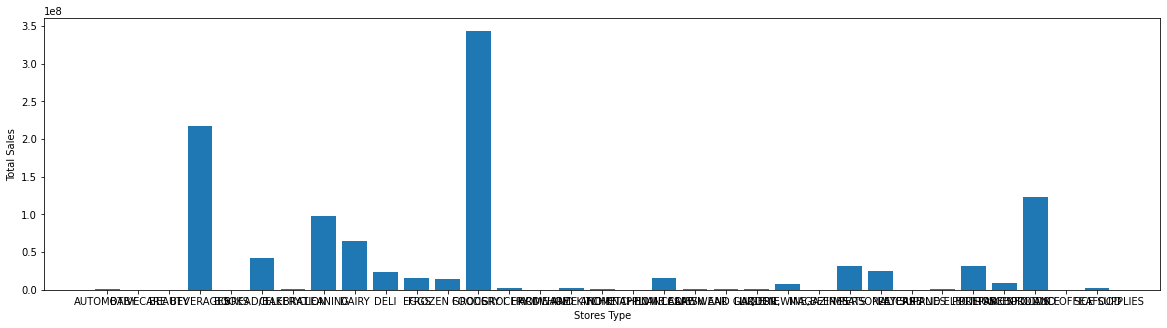

In [ ]:
#Lets analyse the sales that gives the total sales for a product family from all the stores
store_family=train[['family','sales']].groupby('family').sum()
store_family=store_family.reset_index()
fig=plt.figure(figsize=(20,5))
plt.bar(store_family['family'],store_family['sales'])
plt.xlabel('Stores Type')
plt.ylabel('Total Sales')
plt.show()


In [ ]:
le = LabelEncoder()
train['family']=le.fit_transform(train['family'])
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,0,0.0,0
1,1,2013-01-01,1,1,0.0,0
2,2,2013-01-01,1,2,0.0,0
3,3,2013-01-01,1,3,0.0,0
4,4,2013-01-01,1,4,0.0,0


**Test Dataset**

1.The test data, having the same features as the training data. We have to predict the target sales for the dates in this file.

2.The dates in the test data are for the 15 days after the last date in the training data.

**Import the data set and see a overall details**

In [ ]:
test=pd.read_csv('/content/drive/MyDrive/time series forecat project/test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


**From above we can see that date column data type is object. Lets make it to datetime format for further analysis.**

In [ ]:
test['date'] = pd.to_datetime(test['date'])
test['family']=le.fit_transform(test['family'])
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,0,0
1,3000889,2017-08-16,1,1,0
2,3000890,2017-08-16,1,2,2
3,3000891,2017-08-16,1,3,20
4,3000892,2017-08-16,1,4,0


In [ ]:
#Lets create a function that will test the stationarity of dataset and we can use this frequently.
def adf_test(series):
    result=adfuller(series)
    print('p value after test is ',result[1])
    if result[1] > 0.05:
        print('Null Hypothesis rejected and data set is not a stationary')
    else:
        print('Null Hypothesis can not be rejected and data set is a stationary')

In [ ]:
sales_train=train[['date','sales']].groupby('date').sum()
adf_test(sales_train['sales'])

p value after test is  0.08969592175787444
Null Hypothesis rejected and data set is not a stationary


In [ ]:
#From above we can crealy see that our data set is not a stationary data set
sales_train['1shifted sales'] = sales_train['sales'] - sales_train ['sales'].shift(1)
print(sales_train.head())
sales_train = sales_train.dropna()
adf_test(sales_train['1shifted sales'])

                    sales  1shifted sales
date                                     
2013-01-01    2511.618999             NaN
2013-01-02  496092.417944   493580.798945
2013-01-03  361461.231124  -134631.186820
2013-01-04  354459.677093    -7001.554031
2013-01-05  477350.121229   122890.444136
p value after test is  4.573768417346642e-21
Null Hypothesis can not be rejected and data set is a stationary


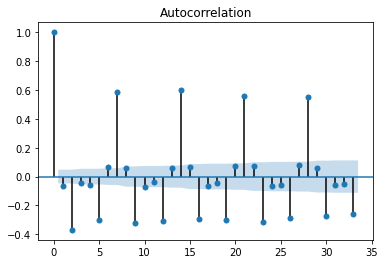

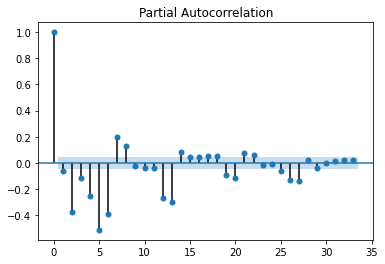

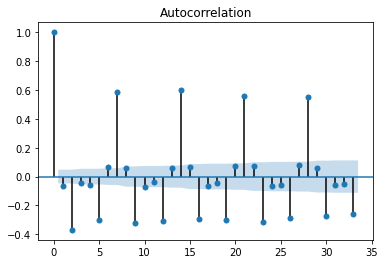

In [ ]:
plot_pacf(sales_train['1shifted sales'])
plot_acf(sales_train['1shifted sales'])

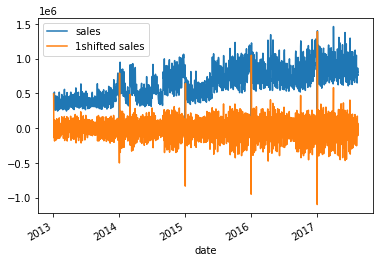

In [ ]:
sales_train.plot()

From above we can clearly see the seasonality in our dataset. At the end of each year we can clearly see the increase in sales and some decrease in sales at mid of year.

In [ ]:
#Let's start our ARIMA model with proper data.
sales_train['1shifted sales'] = sales_train['1shifted sales'].astype('float64')

In [ ]:
model_arima = ARIMA(sales_train['sales'],order = (0,1,0))
model_arima_fit = model_arima.fit()
model_arima_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1683
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -22536.381
Date:                Mon, 12 Sep 2022   AIC                          45074.763
Time:                        14:29:59   BIC                          45080.191
Sample:                             0   HQIC                         45076.773
                               - 1683                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.542e+10   4.11e+08     61.766      0.000    2.46e+10    2.62e+10
===================================================================================
Ljung-Box (L1) (Q):                   6.34   Jarque-Bera (JB):              3494.94
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

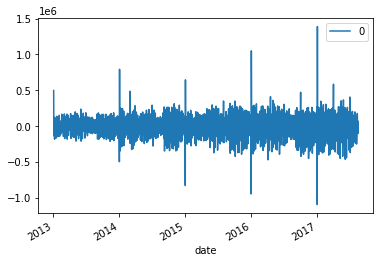

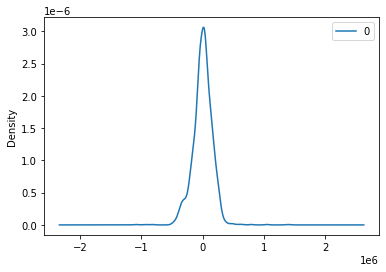

                  0
count  1.683000e+03
mean   4.531562e+02
std    1.599294e+05
min   -1.096930e+06
25%   -7.967363e+04
50%    9.784374e+03
75%    9.559774e+04
max    1.390224e+06


In [ ]:
#Let's plot residuals for our ARIMA model
residuals = pd.DataFrame(model_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

In [ ]:
#We have created our model and now its time to predict the data.
pred_arima=model_arima_fit.predict(start=datetime(2017,6,1),end=datetime(2017,7,1))
pred_arima

date
2017-06-01    8.580621e+05
2017-06-02    7.668592e+05
2017-06-03    9.184213e+05
2017-06-04    1.176138e+06
2017-06-05    1.376512e+06
2017-06-06    9.126939e+05
2017-06-07    8.055466e+05
2017-06-08    8.429798e+05
2017-06-09    6.670998e+05
2017-06-10    7.951161e+05
2017-06-11    9.937327e+05
2017-06-12    1.213674e+06
2017-06-13    7.683498e+05
2017-06-14    7.294130e+05
2017-06-15    7.858859e+05
2017-06-16    6.603383e+05
2017-06-17    8.347864e+05
2017-06-18    1.096134e+06
2017-06-19    9.651441e+05
2017-06-20    7.911464e+05
2017-06-21    7.873267e+05
2017-06-22    7.661590e+05
2017-06-23    6.098688e+05
2017-06-24    7.610497e+05
2017-06-25    9.632682e+05
2017-06-26    1.092611e+06
2017-06-27    7.553678e+05
2017-06-28    6.822185e+05
2017-06-29    7.318970e+05
2017-06-30    6.308118e+05
2017-07-01    8.022731e+05
Name: predicted_mean, dtype: float64

In [ ]:
#SARIMAX Model
model_SARIMA=SARIMAX(sales_train['sales'],order=(3,0,6),seasonal_order=(0,1,0,12))
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1683
Model:             SARIMAX(3, 0, 6)x(0, 1, [], 12)   Log Likelihood              -22433.675
Date:                             Mon, 12 Sep 2022   AIC                          44887.350
Time:                                     14:33:36   BIC                          44941.562
Sample:                                          0   HQIC                         44907.437
                                            - 1683                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5293      0.019     27.611      0.000       0.492       0.567
ar.L2         -0.5538      0.014    -38.926      0.000      -0.582      -0.526
ar.L3          0.9063      0.019     48.449      0.000       0.870       0.943
ma.L1          0.3218      0.021     15.478      0.000       0.281       0.363
ma.L2          0.8083      0.018     45.459      0.000       0.773       0.843
ma.L3         -0.3649      0.019    -19.402      0.000      -0.402      -0.328
ma.L4         -0.6226      0.016    -38.761      0.000      -0.654      -0.591
ma.L5         -0.6791      0.015    -45.140      0.000      -0.709      -0.650
ma.L6         -0.4295      0.023    -19.006      0.000      -0.474      -0.385
sigma2      3.587e+10   3.42e-13   1.05e+23      0.000    3.59e+10    3.59e+10
===================================================================================
Ljung-Box (L1) (Q):                  15.99   Jarque-Bera (JB):              5507.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.82e+38. Standard errors may be unstable.
"""

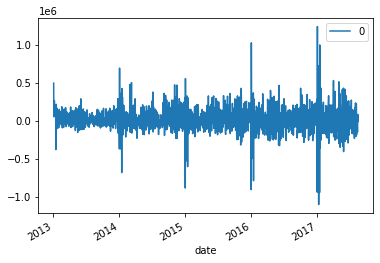

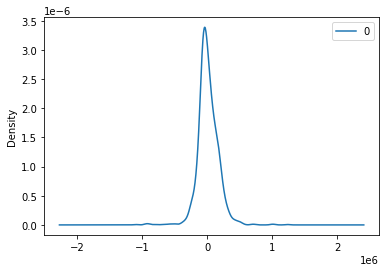

                  0
count  1.683000e+03
mean   1.504245e+04
std    1.590667e+05
min   -1.102240e+06
25%   -7.026293e+04
50%   -1.720953e+03
75%    9.967078e+04
max    1.241364e+06


In [ ]:
residuals = pd.DataFrame(model_SARIMA_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

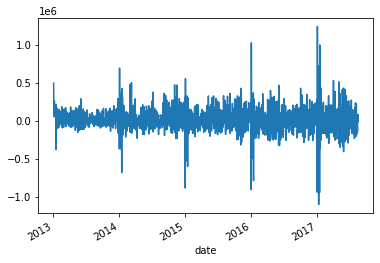

In [ ]:
pred_Sarima=model_SARIMA_fit.predict(start=datetime(2017,6,1),end=datetime(2017,7,1))
residuals=sales_train['sales']-pred_Sarima
model_SARIMA_fit.resid.plot()

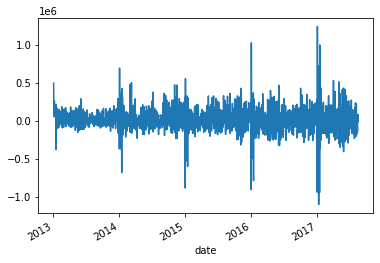

In [ ]:
#Let's predict the sales with the help of our SARIMAX model and plot residuals
pred_Sarima=model_SARIMA_fit.predict(start=datetime(2017,8,10),end=datetime(2017,8,13))
residuals=sales_train['sales']-pred_Sarima
model_SARIMA_fit.resid.plot()